
# **Import Dependences**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import imblearn
import sklearn
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [4]:
tf.test.is_gpu_available()

False

# **Read Dataset**

In [8]:
IMG_SIZE = 128 
BATCH_SIZE = 128 
DATASET_DIR_1 = 'HAM10000_images_part_1/'
DATASET_DIR_2 = 'HAM10000_images_part_2/'
metadata_path = 'HAM10000_metadata.csv'
paths = [DATASET_DIR_1,DATASET_DIR_2]

In [10]:
df = pd.read_csv(metadata_path)

In [13]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
def get_full_image_path(filename):
#     print(os.path.join(DATASET_DIR_1, filename +'.jpg'))
    if os.path.exists(os.path.join(DATASET_DIR_1, filename+'.jpg')):
        return os.path.join(DATASET_DIR_1, filename+'.jpg')
    elif os.path.exists(os.path.join(DATASET_DIR_2, filename+'.jpg')):
        return os.path.join(DATASET_DIR_2, filename+'.jpg')
    else:
        return None  # or handle missing files as needed

df['image_id'] = df['image_id'].apply(get_full_image_path)

In [15]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,HAM10000_images_part_1/ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
1,HAM_0000118,HAM10000_images_part_1/ISIC_0025030.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,HAM10000_images_part_1/ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
3,HAM_0002730,HAM10000_images_part_1/ISIC_0025661.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,HAM10000_images_part_2/ISIC_0031633.jpg,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,HAM10000_images_part_2/ISIC_0033084.jpg,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,HAM10000_images_part_2/ISIC_0033550.jpg,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,HAM10000_images_part_2/ISIC_0033536.jpg,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,HAM10000_images_part_2/ISIC_0032854.jpg,akiec,histo,80.0,male,face


# **Balance Dataset**

In [16]:
unique_labels = np.unique(df['dx'])
print(unique_labels)
for label in unique_labels:
    print(f"no of samples of class {label} : {list(df['dx']).count(label)}")

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
no of samples of class akiec : 327
no of samples of class bcc : 514
no of samples of class bkl : 1099
no of samples of class df : 115
no of samples of class mel : 1113
no of samples of class nv : 6705
no of samples of class vasc : 142


Text(0.5, 1.0, 'Frequency Distribution of Classes')

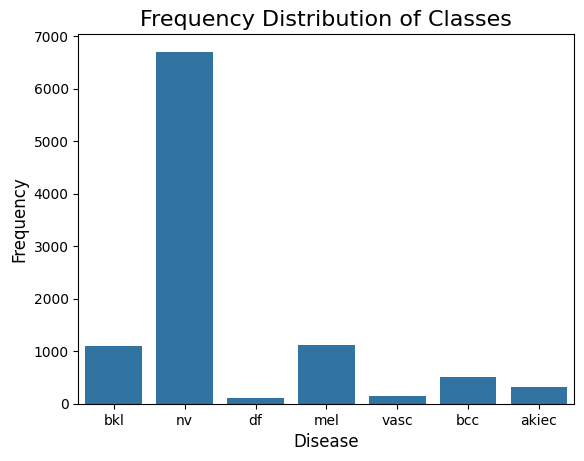

In [17]:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [18]:
sampler = RandomOverSampler()
X,Y = sampler.fit_resample(df.drop(['dx'],axis=1),df['dx'])

In [19]:
X_resampled_df = pd.DataFrame(X, columns=X.columns)
y_resampled_df = pd.DataFrame(Y, columns=[Y.name])

In [20]:
df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

In [21]:
df.shape

(46935, 7)

In [22]:
unique_labels = np.unique(df['dx'])
print(unique_labels)
for label in unique_labels:
    print(f"no of samples of class {label} : {list(df['dx']).count(label)}")

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
no of samples of class akiec : 6705
no of samples of class bcc : 6705
no of samples of class bkl : 6705
no of samples of class df : 6705
no of samples of class mel : 6705
no of samples of class nv : 6705
no of samples of class vasc : 6705


Text(0.5, 1.0, 'Frequency Distribution of Classes')

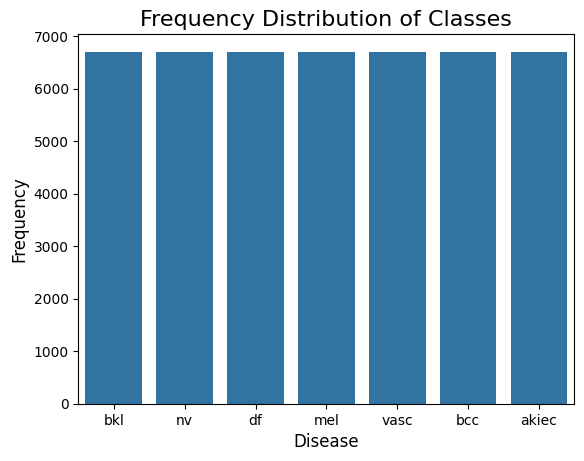

In [23]:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

# **Split data for train and validation**

In [24]:
train_df, val_df = train_test_split(df, test_size=0.3)

# **Image Data Generators**

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255)#,preprocessing_function=equalize)  
val_datagen = ImageDataGenerator(rescale=1./255)#,preprocessing_function=equalize)

In [26]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_id',
    y_col='dx',  
    class_mode='categorical',  
    target_size=(IMG_SIZE, IMG_SIZE),  
    batch_size=BATCH_SIZE,
    workers=8,
    use_multiprocessing=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_id',
    y_col='dx',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    workers=8,
    use_multiprocessing=True
)

Found 32854 validated image filenames belonging to 7 classes.
Found 14081 validated image filenames belonging to 7 classes.


# **Modeling**

## **CNN Model**

In [27]:
cnn_input_layer = Input(shape=(IMG_SIZE,IMG_SIZE,3),name='CNN_Input_layer')

x = Conv2D(filters= 64,kernel_size=(3,3),activation='relu',name='CNN_Layer_1')(cnn_input_layer)
x = MaxPooling2D(pool_size=(2,2),name='Maxpooling_Layer_1')(x)
x = Conv2D(filters= 64,kernel_size=(3,3),activation='relu',name='CNN_Layer_2')(x)
x = MaxPooling2D(pool_size=(2,2),name='Maxpooling_Layer_2')(x)
x = Conv2D(filters= 128,kernel_size=(3,3),activation='relu',name='CNN_Layer_3')(x)
x = MaxPooling2D(pool_size=(2,2),name='Maxpooling_Layer_3')(x)

x = Flatten(name='Flatten_Layer')(x)
x = Dense(units=128,activation='relu',name='Dense_Layer_1')(x)
# x = Dropout(0.4)(x)
x = Dense(units=64,activation='relu',name='Dense_Layer_2')(x)

cnn_output_layer = Dense(units=7,activation='softmax',dtype='float32',name='CNN_Output_Layer')(x)

cnn_model = Model(inputs=cnn_input_layer,outputs=cnn_output_layer,name='CNN_Model')

In [28]:
cnn_model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CNN_Input_layer (InputLayer)    │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Layer_1 (Conv2D)            │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpooling_Layer_1              │ (None, 63, 63, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Layer_2 (Conv2D)            │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpooling_Layer_2              │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Layer_3 (Conv2D)            │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpooling_Layer_3              │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Output_Layer (Dense)        │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,332,679 (12.71 MB)

 Trainable params: 3,332,679 (12.71 MB)

 Non-trainable params: 0 (0.00 B)

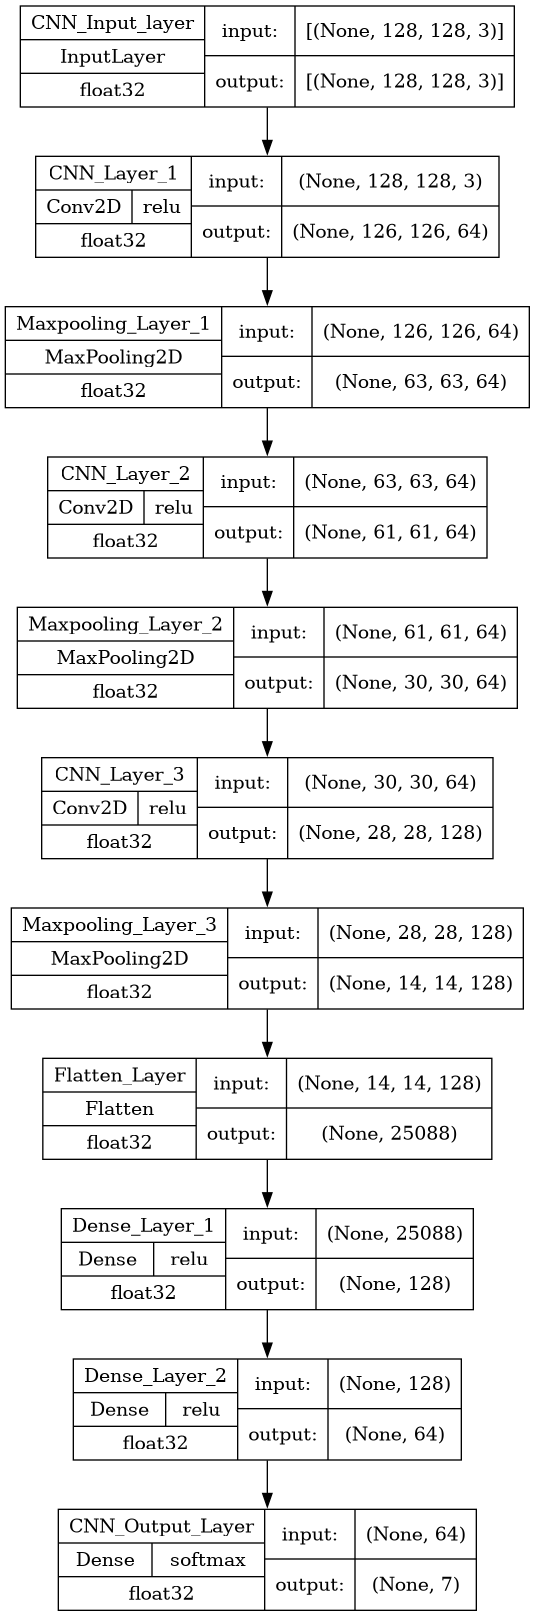

In [22]:
plot_model(model=cnn_model,to_file='CNN Model.png',show_shapes=True,show_dtype=True,show_layer_activations=True)

In [29]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_CNN.keras',
                                                  monitor='val_accuracy',mode='max',save_best_only=True,
                                                 verbose=1)
cnn_model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
# steps_per_epoch = len(img_paths) // BATCH_SIZE

In [30]:
with tf.device("/GPU:0") :
    cnn_history = cnn_model.fit(train_generator,
                                batch_size=BATCH_SIZE,
                                epochs=10,
                                validation_data=val_generator,
                                validation_batch_size=BATCH_SIZE,
                                callbacks=[callback])

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3526 - loss: 1.6001
Epoch 1: val_accuracy improved from -inf to 0.62183, saving model to best_CNN.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.3531 - loss: 1.5990 - val_accuracy: 0.6218 - val_loss: 0.9908
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7122 - loss: 0.7718
Epoch 2: val_accuracy improved from 0.62183 to 0.82821, saving model to best_CNN.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.7124 - loss: 0.7714 - val_accuracy: 0.8282 - val_loss: 0.4813
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8544 - loss: 0.4057
Epoch 3: val_accuracy improved from 0.82821 to 0.86819, saving model to best_CNN.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.8545 - loss: 0.4055 - val_accuracy: 0.8682 - val_loss: 0.3700
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9091 - loss: 0.2555
Epoch 4: val_accuracy improved from 0.86819 to 0

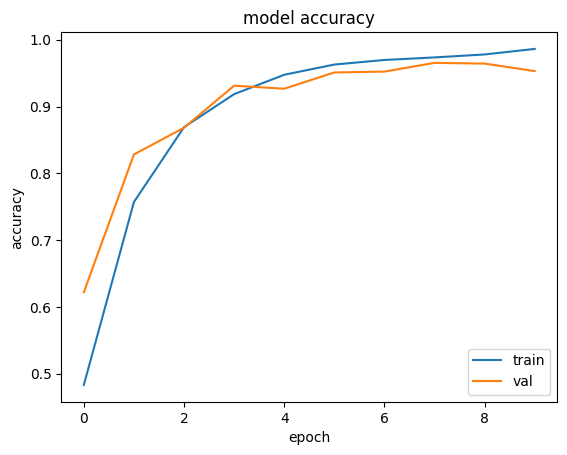

In [31]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

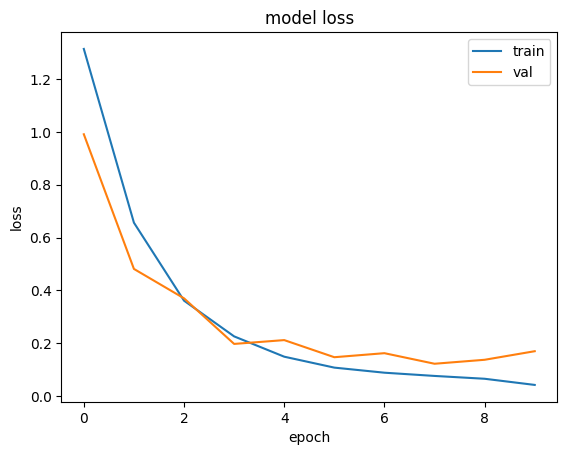

In [32]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## **VGG 16**

In [33]:
img_shape =(IMG_SIZE,IMG_SIZE,3)

In [35]:
Name= "VGG16"
classifier = VGG16(
            include_top = False,input_shape=img_shape,
             weights='imagenet'
           )

In [36]:
classifier.trainable = False

In [37]:
vgg16_model = Sequential([
    classifier,
    GlobalMaxPooling2D(name='GlobalMaxPooling2D_Layer'),
    BatchNormalization(name='Batchnormalization_Layer_1'),
    Dense(units=128,activation='relu',name='Dense_Layer_1',use_bias=False),
    BatchNormalization(name='Batchnormalization_Layer_2'),
    Dropout(0.5),
    Dense(units=7,activation='softmax',name=Name+'_Output_Layer'),
],name=Name+'_Model')

In [38]:
vgg16_model.summary()

Model: "VGG16_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling2D_Layer        │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_1      │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 128)            │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_2      │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VGG16_Output_Layer (Dense)      │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,783,687 (56.40 MB)

 Trainable params: 67,719 (264.53 KB)

 Non-trainable params: 14,715,968 (56.14 MB)

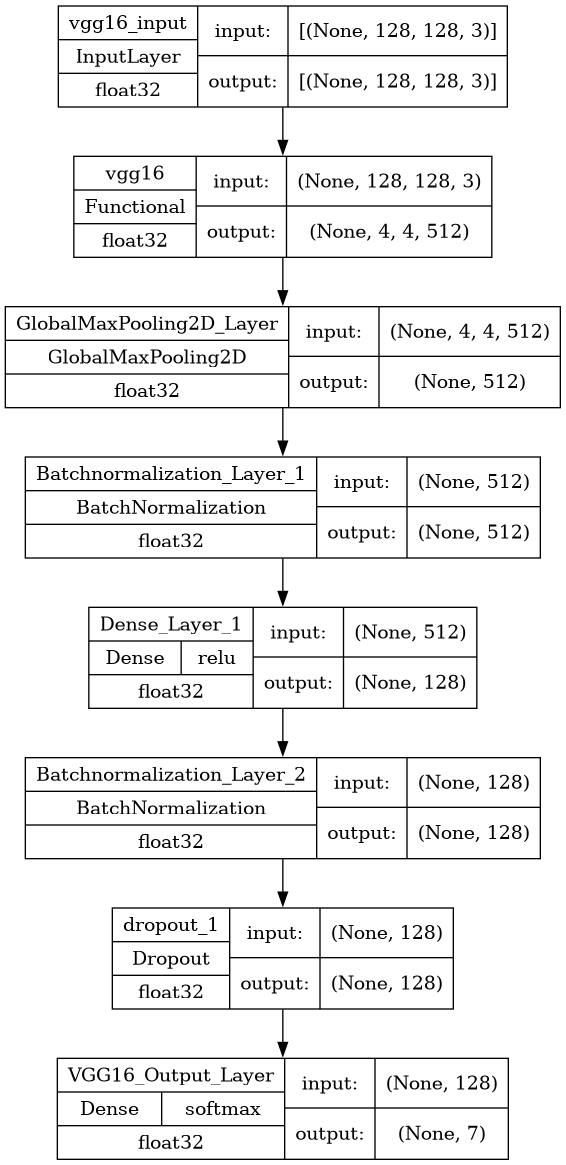

In [42]:
plot_model(model=vgg16_model,to_file=Name+' Model.png',show_shapes=True,show_dtype=True,show_layer_activations=True)

In [40]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_'+Name+'.keras',
                                                  monitor='val_accuracy',mode='max',save_best_only=True,
                                                 verbose=1)
vgg16_model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [41]:
with tf.device("/GPU:0") :
    vgg16_history = vgg16_model.fit(train_generator,
                                batch_size=BATCH_SIZE,
                                epochs=10,
                                validation_data=val_generator,
                                validation_batch_size=BATCH_SIZE,
                                callbacks=[callback])

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4472 - loss: 1.6868
Epoch 1: val_accuracy improved from -inf to 0.68248, saving model to best_VGG16.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 1558s 6s/step - accuracy: 0.4476 - loss: 1.6854 - val_accuracy: 0.6825 - val_loss: 1.0539
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6899 - loss: 0.8628
Epoch 2: val_accuracy improved from 0.68248 to 0.80158, saving model to best_VGG16.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 1551s 6s/step - accuracy: 0.6900 - loss: 0.8625 - val_accuracy: 0.8016 - val_loss: 0.6336
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7676 - loss: 0.6451
Epoch 3: val_accuracy improved from 0.80158 to 0.85008, saving model to best_VGG16.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 1564s 6s/step - accuracy: 0.7676 - loss: 0.6450 - val_accuracy: 0.8501 - val_loss: 0.4671
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8149 - loss: 0.5244
Epoch 4: val_accuracy improved from 0.8

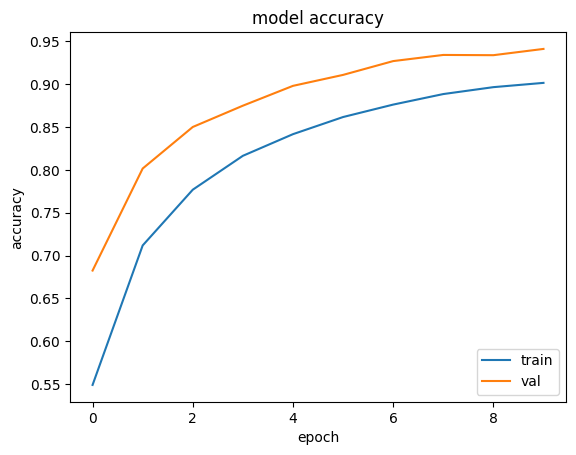

In [42]:
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

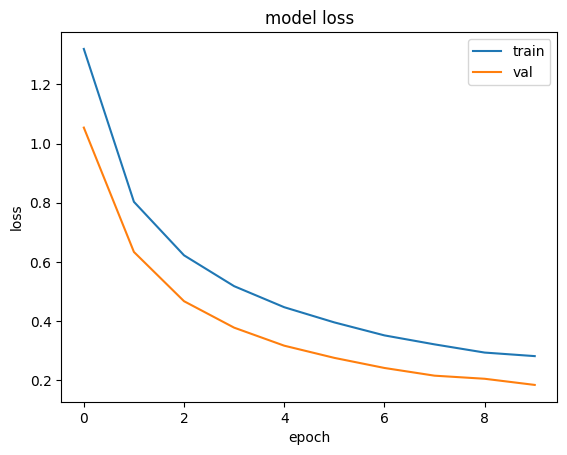

In [43]:
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## **VGG 19**

In [44]:
img_shape =(IMG_SIZE,IMG_SIZE,3)

In [49]:
Name= "VGG19"
classifier = VGG19(
            include_top = False,input_shape=img_shape,
             weights='imagenet'
           )

In [50]:
classifier.trainable = False

In [51]:
vgg19_model = Sequential([
    classifier,
    GlobalMaxPooling2D(name='GlobalMaxPooling2D_Layer'),
    BatchNormalization(name='Batchnormalization_Layer_1'),
    Dense(units=128,activation='relu',name='Dense_Layer_1',use_bias=False),
    BatchNormalization(name='Batchnormalization_Layer_2'),
    Dropout(0.5),
    Dense(units=7,activation='softmax',name=Name+'_Output_Layer'),
],name=Name+'_Model')

In [52]:
vgg19_model.summary()

Model: "VGG19_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling2D_Layer        │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_1      │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 128)            │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_2      │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VGG19_Output_Layer (Dense)      │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,093,383 (76.65 MB)

 Trainable params: 67,719 (264.53 KB)

 Non-trainable params: 20,025,664 (76.39 MB)

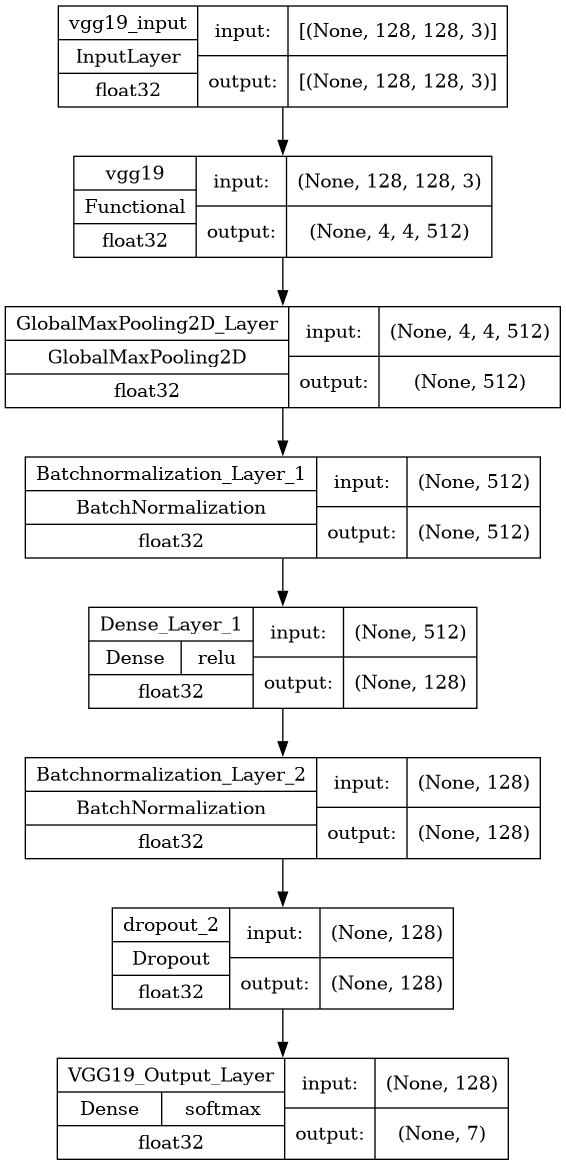

In [52]:
plot_model(model=vgg19_model,to_file=Name+' Model.png',show_shapes=True,show_dtype=True,show_layer_activations=True)

In [54]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_'+Name+'.keras',
                                                  monitor='val_accuracy',mode='max',save_best_only=True,
                                                 verbose=1)
vgg19_model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [55]:
with tf.device("/GPU:0") :
    vgg19_history = vgg19_model.fit(train_generator,
                                batch_size=BATCH_SIZE,
                                epochs=10,
                                validation_data=val_generator,
                                validation_batch_size=BATCH_SIZE,
                                callbacks=[callback])

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4258 - loss: 1.7562
Epoch 1: val_accuracy improved from -inf to 0.58511, saving model to best_VGG19.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 2016s 8s/step - accuracy: 0.4262 - loss: 1.7548 - val_accuracy: 0.5851 - val_loss: 1.2370
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6828 - loss: 0.8816
Epoch 2: val_accuracy improved from 0.58511 to 0.79185, saving model to best_VGG19.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 1992s 8s/step - accuracy: 0.6829 - loss: 0.8814 - val_accuracy: 0.7918 - val_loss: 0.6839
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7585 - loss: 0.6783
Epoch 3: val_accuracy improved from 0.79185 to 0.84767, saving model to best_VGG19.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 1992s 8s/step - accuracy: 0.7585 - loss: 0.6782 - val_accuracy: 0.8477 - val_loss: 0.4782
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8011 - loss: 0.5584
Epoch 4: val_accuracy improved from 0.8

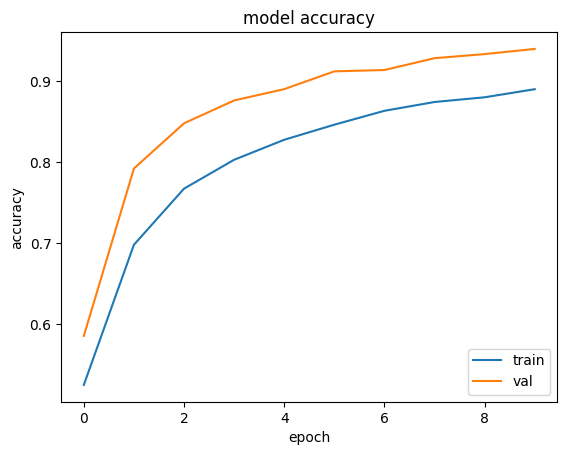

In [56]:
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

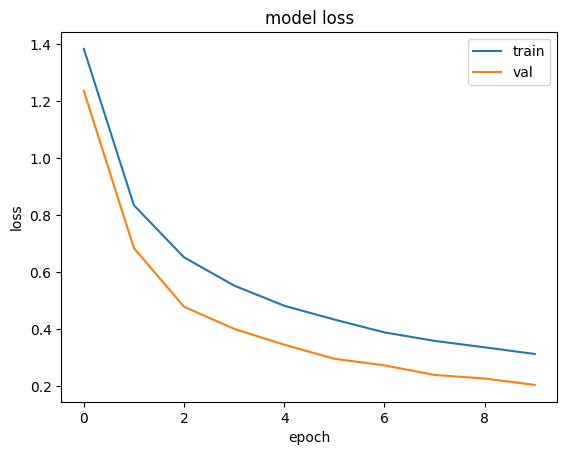

In [57]:
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## **Inception V3**

In [58]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)

In [60]:
Name= "InceptionV3"
classifier = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)

In [61]:
classifier.trainable = False

In [62]:
inceptionv3_model = Sequential([
    classifier,
    GlobalMaxPooling2D(name='GlobalMaxPooling2D_Layer'),
    BatchNormalization(name='Batchnormalization_Layer_1'),
    Dense(units=128,activation='relu',name='Dense_Layer_1',use_bias=False),
    BatchNormalization(name='Batchnormalization_Layer_2'),
    Dropout(0.5),
    Dense(units=7,activation='softmax',name=Name+'_Output_Layer'),
],name=Name+'_Model')

In [63]:
inceptionv3_model.summary()

Model: "InceptionV3_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling2D_Layer        │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_1      │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 128)            │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_2      │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ InceptionV3_Output_Layer        │ (None, 7)              │           903 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,074,535 (84.21 MB)

 Trainable params: 267,399 (1.02 MB)

 Non-trainable params: 21,807,136 (83.19 MB)

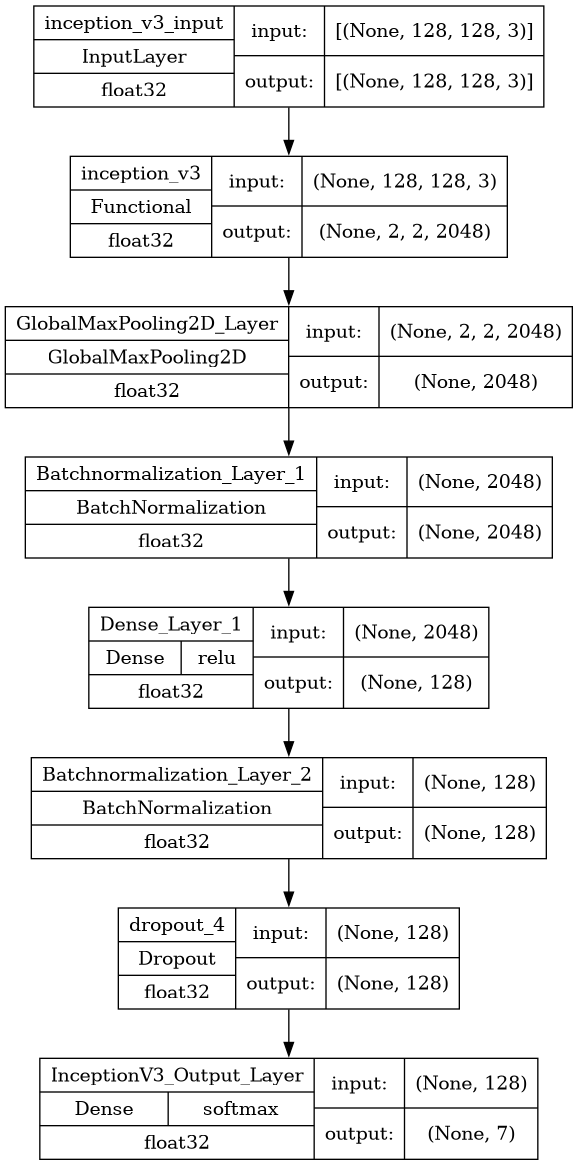

In [71]:
plot_model(model=inceptionv3_model,to_file=Name+' Model.png',show_shapes=True,show_dtype=True,show_layer_activations=True)

In [65]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_'+Name+'.keras',
                                                  monitor='val_accuracy',mode='max',save_best_only=True,
                                                 verbose=1)
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [66]:
with tf.device("/GPU:0") :
    inceptionv3_history = inceptionv3_model.fit(train_generator,
                                batch_size=BATCH_SIZE,
                                epochs=10,
                                validation_data=val_generator,
                                validation_batch_size=BATCH_SIZE,
                                callbacks=[callback])

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3225 - loss: 2.1951
Epoch 1: val_accuracy improved from -inf to 0.66132, saving model to best_InceptionV3.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.3228 - loss: 2.1936 - val_accuracy: 0.6613 - val_loss: 0.9810
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5822 - loss: 1.2091
Epoch 2: val_accuracy improved from 0.66132 to 0.76166, saving model to best_InceptionV3.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.5822 - loss: 1.2087 - val_accuracy: 0.7617 - val_loss: 0.7274
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6842 - loss: 0.9224
Epoch 3: val_accuracy improved from 0.76166 to 0.81521, saving model to best_InceptionV3.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.6843 - loss: 0.9223 - val_accuracy: 0.8152 - val_loss: 0.5971
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7379 - loss: 0.7556
Epoch 4: val_accuracy im

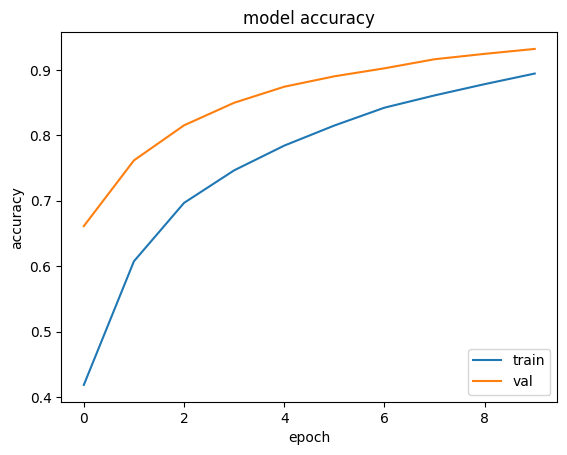

In [67]:
plt.plot(inceptionv3_history.history['accuracy'])
plt.plot(inceptionv3_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

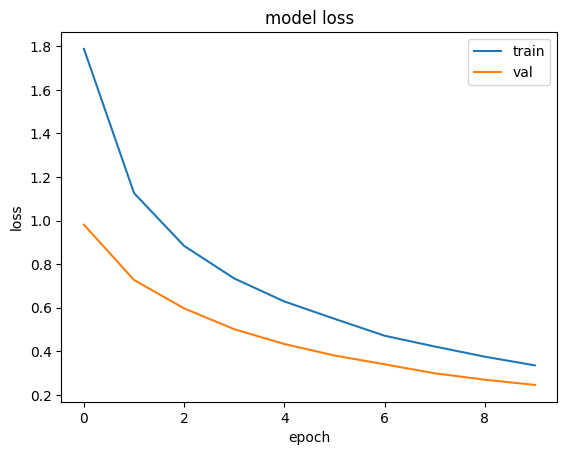

In [68]:
plt.plot(inceptionv3_history.history['loss'])
plt.plot(inceptionv3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## **ResNet50**

In [69]:
img_shape =(IMG_SIZE,IMG_SIZE,3)

In [71]:
Name= "ResNet50"
classifier = ResNet50(
            include_top = False,input_shape=img_shape,
             weights='imagenet')

In [72]:
classifier.trainable = False

In [73]:
resnet50_model = Sequential([
    classifier,
    GlobalMaxPooling2D(name='GlobalMaxPooling2D_Layer'),
    BatchNormalization(name='Batchnormalization_Layer_1'),
    Dense(units=128,activation='relu',name='Dense_Layer_1',use_bias=False),
    BatchNormalization(name='Batchnormalization_Layer_2'),
    Dropout(0.5),
    Dense(units=7,activation='softmax',name='ResNet50_Output_Layer'),
],name=Name+'_Model')

In [74]:
resnet50_model.summary()

Model: "ResNet50_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling2D_Layer        │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_1      │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 128)            │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batchnormalization_Layer_2      │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ResNet50_Output_Layer (Dense)   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,859,463 (91.02 MB)

 Trainable params: 267,399 (1.02 MB)

 Non-trainable params: 23,592,064 (90.00 MB)

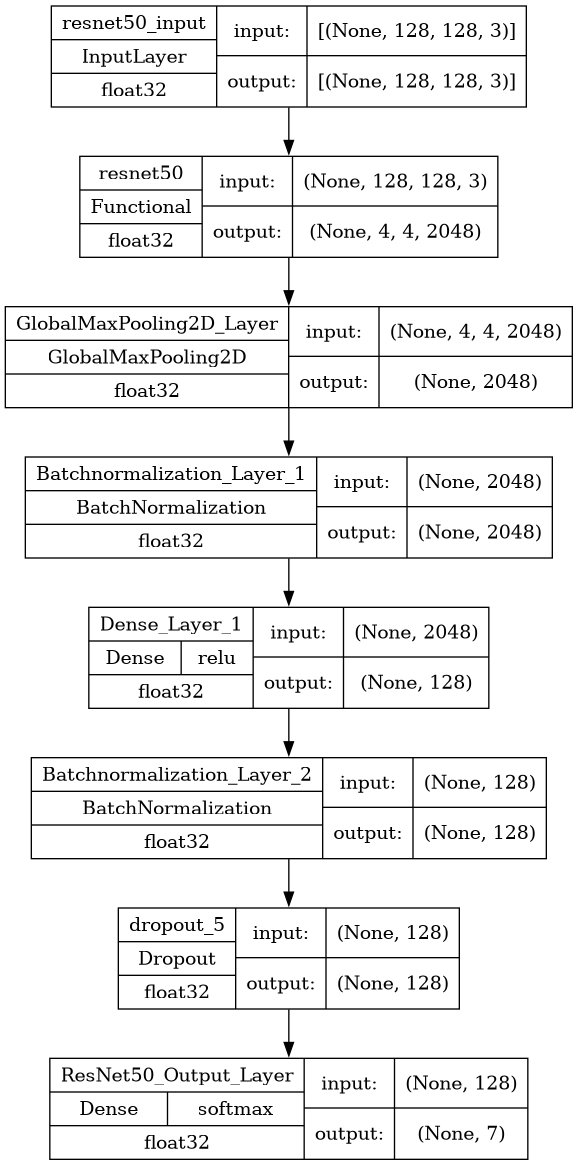

In [81]:
plot_model(model=resnet50_model,to_file=Name+' Model.png',show_shapes=True,show_dtype=True,show_layer_activations=True)

In [75]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_'+Name+'.keras',
                                                  monitor='val_accuracy',mode='max',save_best_only=True,
                                                 verbose=1)
resnet50_model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [76]:
with tf.device("/GPU:0") :
    resnet50_history = resnet50_model.fit(train_generator,
                                batch_size=BATCH_SIZE,
                                epochs=10,
                                validation_data=val_generator,
                                validation_batch_size=BATCH_SIZE,
                                callbacks=[callback])

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3888 - loss: 1.8566
Epoch 1: val_accuracy improved from -inf to 0.27541, saving model to best_ResNet50.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 842s 3s/step - accuracy: 0.3891 - loss: 1.8554 - val_accuracy: 0.2754 - val_loss: 2.1128
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5872 - loss: 1.1295
Epoch 2: val_accuracy improved from 0.27541 to 0.62943, saving model to best_ResNet50.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 844s 3s/step - accuracy: 0.5872 - loss: 1.1294 - val_accuracy: 0.6294 - val_loss: 1.1033
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6595 - loss: 0.9324
Epoch 3: val_accuracy improved from 0.62943 to 0.77218, saving model to best_ResNet50.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 840s 3s/step - accuracy: 0.6596 - loss: 0.9323 - val_accuracy: 0.7722 - val_loss: 0.7164
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6975 - loss: 0.8339
Epoch 4: val_accuracy improved fr

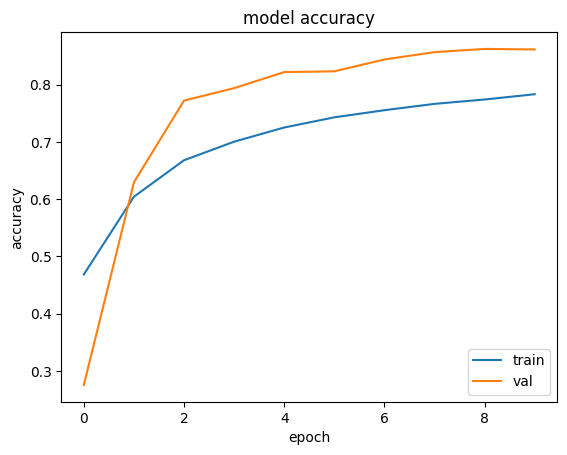

In [77]:
plt.plot(resnet50_history.history['accuracy'])
plt.plot(resnet50_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

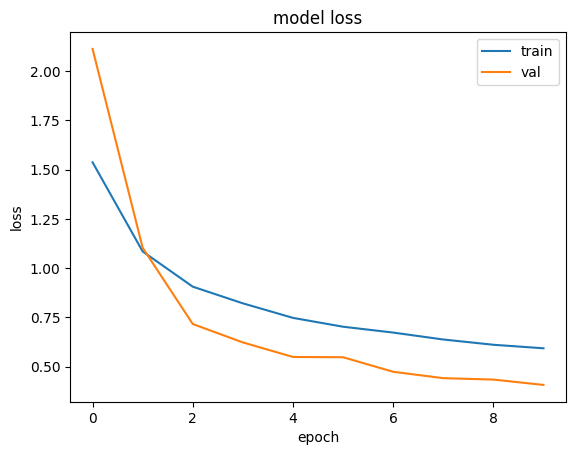

In [78]:
plt.plot(resnet50_history.history['loss'])
plt.plot(resnet50_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# **CNN *vs* MobileNetV2 *vs* VGG16 *vs* VGG19 *vs* Xception *vs* InceptionV3 *vs* ResNet50**

In [79]:
history = {
    "CNN": {"accuracy": cnn_history.history['accuracy'],"val_accuracy": cnn_history.history['val_accuracy'] ,"loss": cnn_history.history['loss']},
    "VGG16": {"accuracy": vgg16_history.history['accuracy'],"val_accuracy": vgg16_history.history['val_accuracy'], "loss": vgg16_history.history['loss']},
    "VGG19": {"accuracy": vgg19_history.history['accuracy'],"val_accuracy": vgg19_history.history['val_accuracy'], "loss": vgg19_history.history['loss']},
    "InceptionV3": {"accuracy": inceptionv3_history.history['accuracy'],"val_accuracy": inceptionv3_history.history['val_accuracy'], "loss": inceptionv3_history.history['loss']},
    "ResNet50": {"accuracy": resnet50_history.history['accuracy'],"val_accuracy": resnet50_history.history['val_accuracy'], "loss": resnet50_history.history['loss']}
}

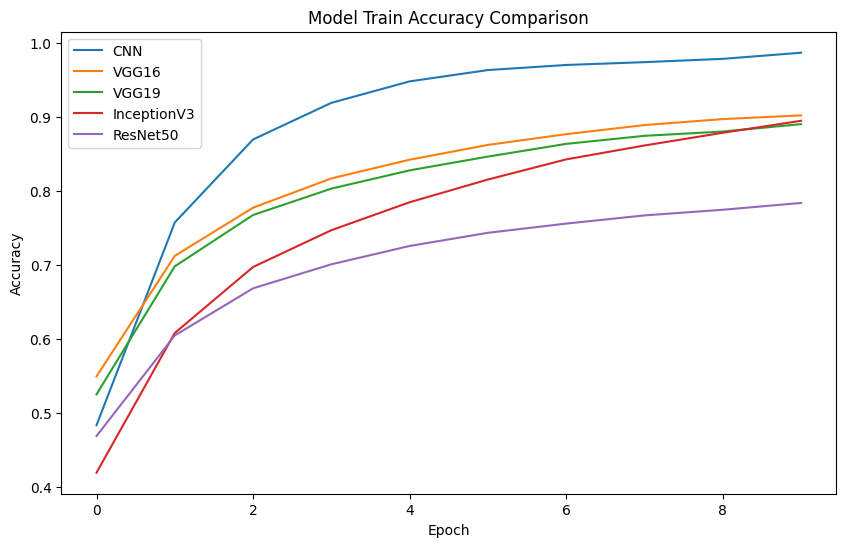

In [80]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['accuracy'], label=model)
plt.title('Model Train Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

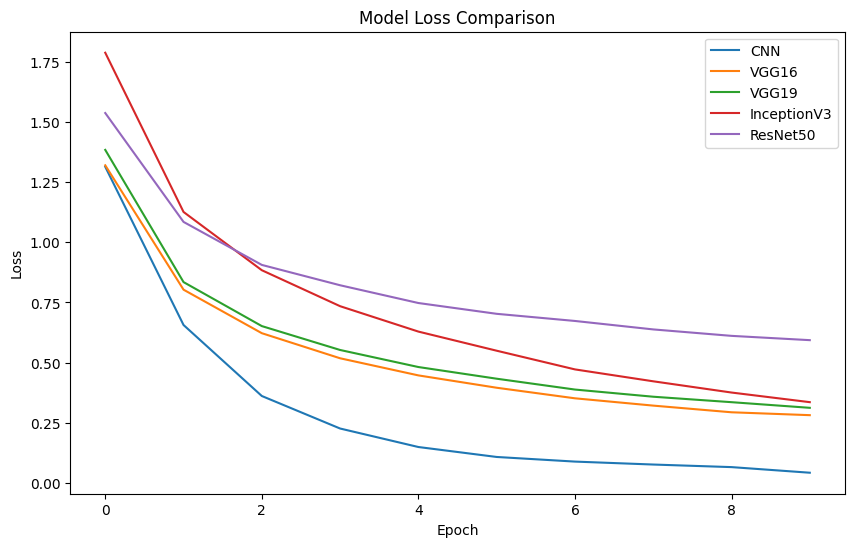

In [81]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['loss'], label=model)
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

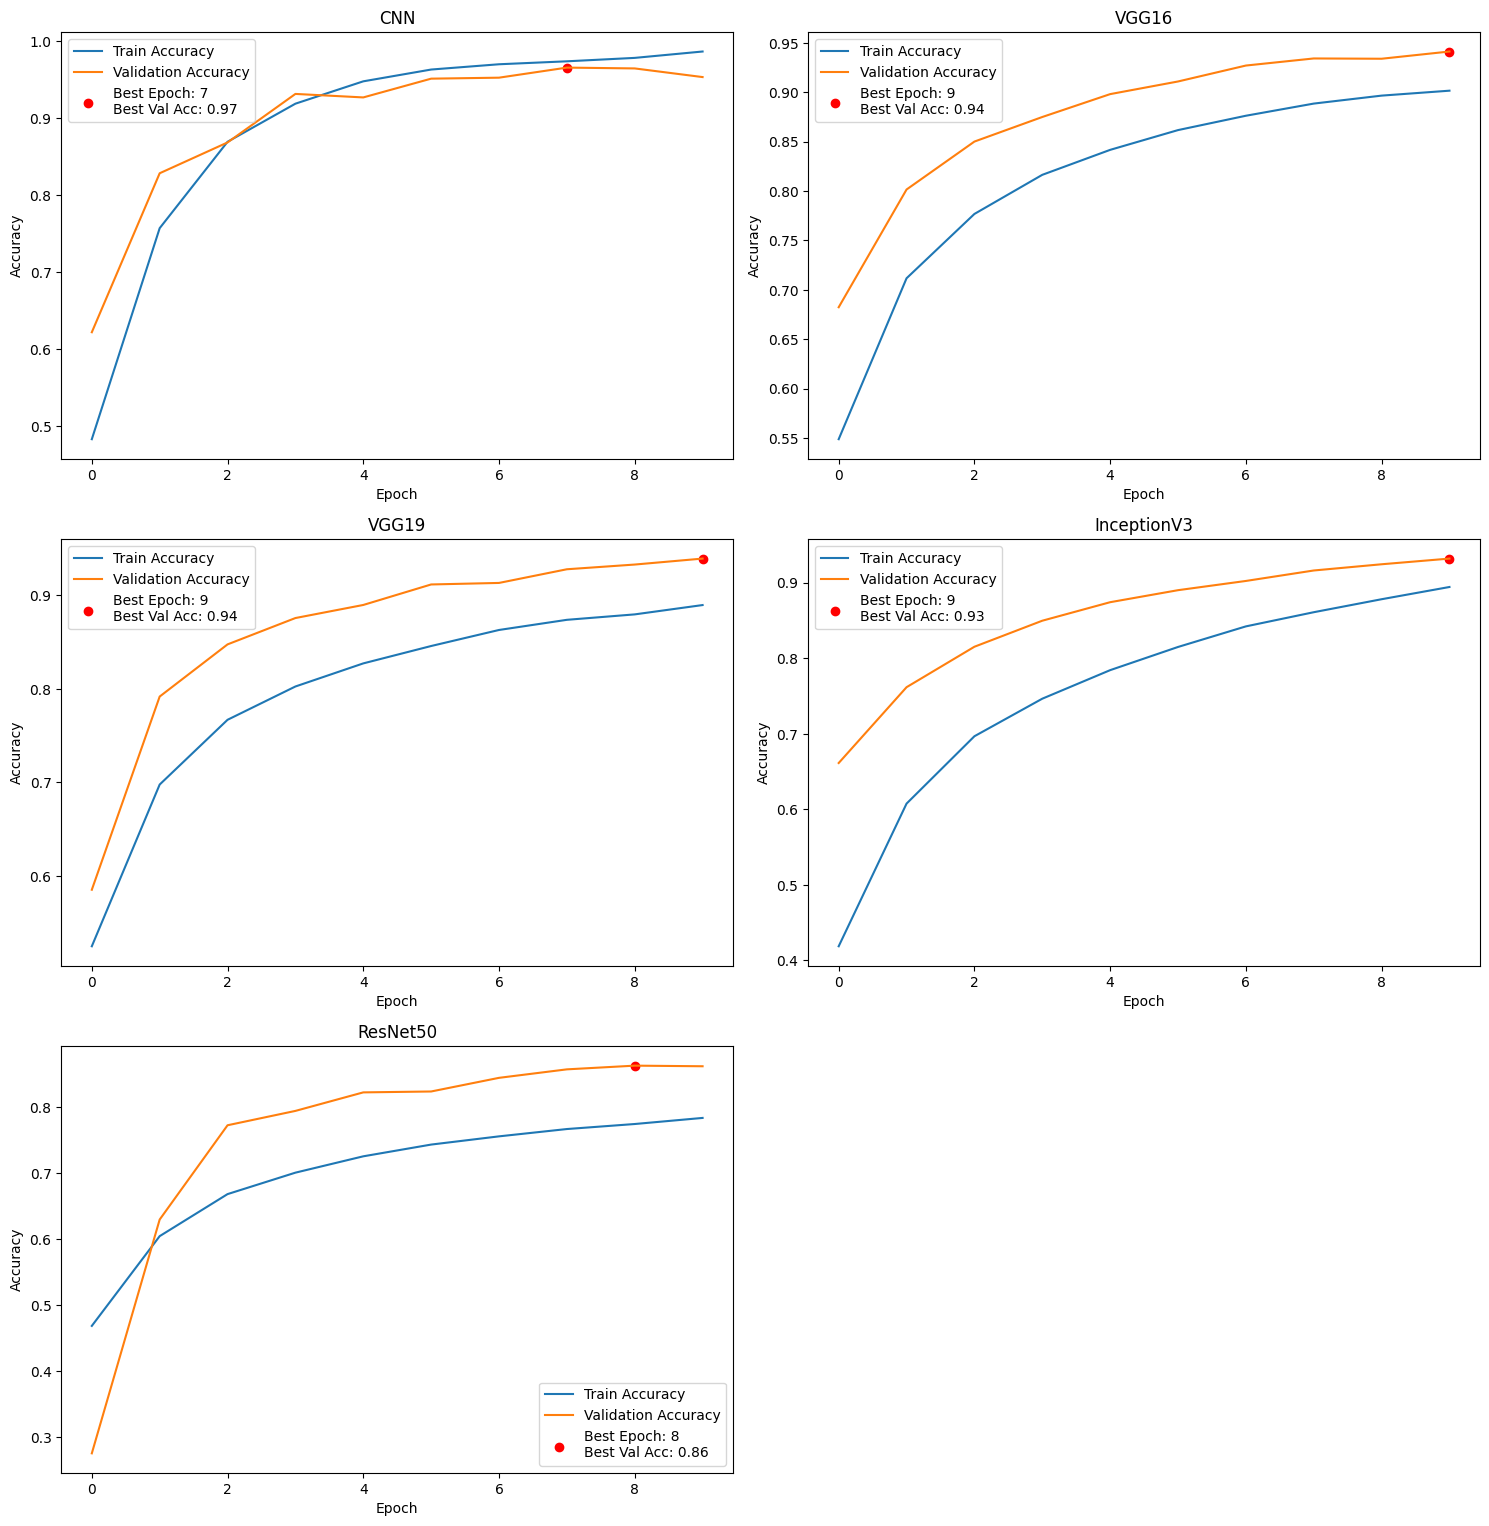

In [82]:
plt.figure(figsize=(15, 20))
for i, (model_name, model_history) in enumerate(history.items(), 1):
    plt.subplot(4, 2, i) 
    plt.plot(model_history['accuracy'], label='Train Accuracy')
    plt.plot(model_history['val_accuracy'], label='Validation Accuracy')

    max_val_acc_epoch = model_history['val_accuracy'].index(max(model_history['val_accuracy']))
    max_val_acc = max(model_history['val_accuracy'])

    plt.scatter(max_val_acc_epoch, max_val_acc, color='red', label=f'Best Epoch: {max_val_acc_epoch}\nBest Val Acc: {max_val_acc:.2f}')

    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

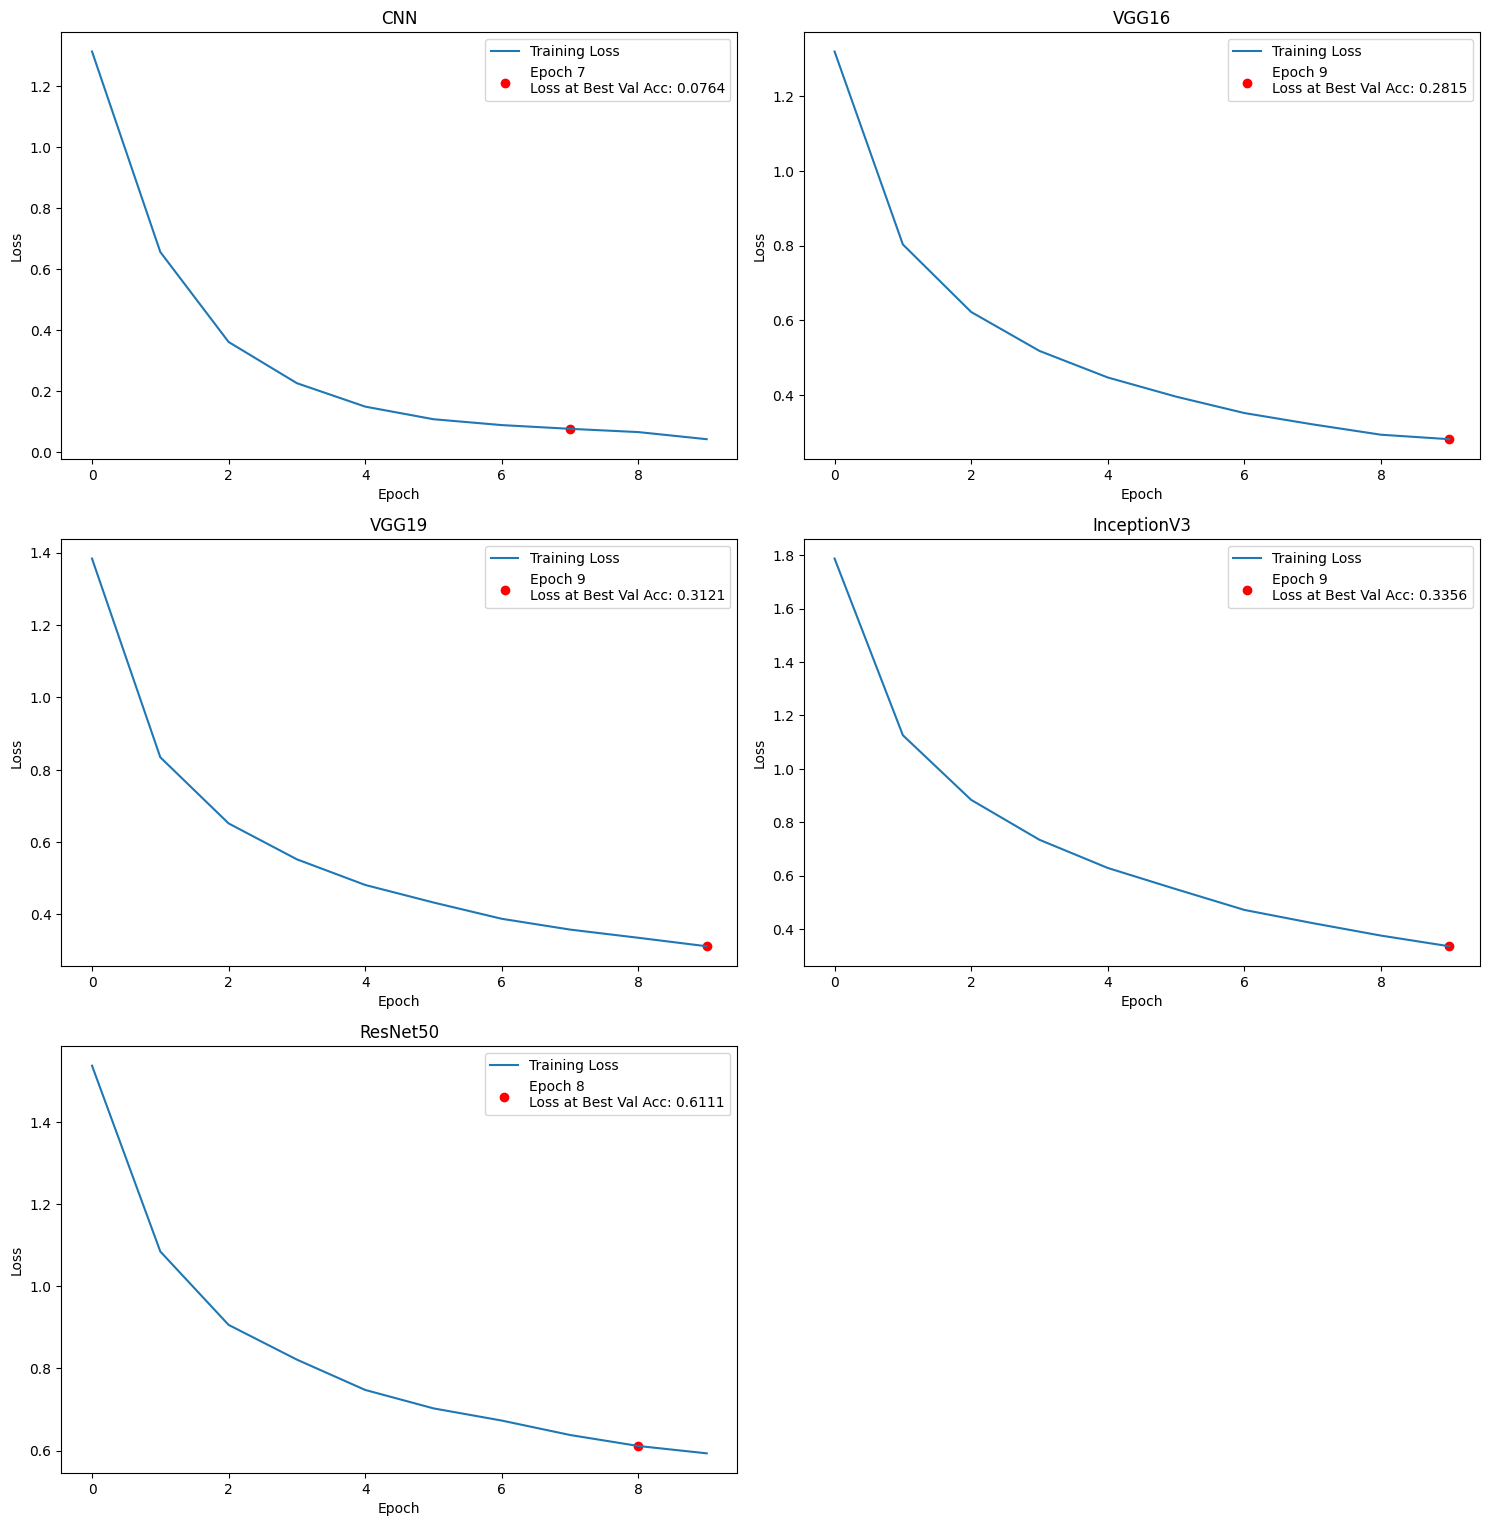

In [83]:
plt.figure(figsize=(15, 20))

for i, (model_name, model_history) in enumerate(history.items(), 1):
    plt.subplot(4, 2, i) 
    plt.plot(model_history['loss'], label='Training Loss')

    max_val_acc_epoch = model_history['val_accuracy'].index(max(model_history['val_accuracy']))
    max_val_acc = max(model_history['val_accuracy'])
    loss_at_max_val_acc = model_history['loss'][max_val_acc_epoch]
    
    plt.scatter(max_val_acc_epoch, loss_at_max_val_acc, color='red', label=f'Epoch {max_val_acc_epoch}\nLoss at Best Val Acc: {loss_at_max_val_acc:.4f}')

    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

## **Compare Between Best model along 100 epoch of each one**

In [84]:
best_CNN = load_model('best_CNN.keras')
best_VGG16 = load_model('best_VGG16.keras')
best_VGG19 = load_model('best_VGG19.keras')
best_InceptionV3 = load_model('best_InceptionV3.keras')
best_ResNet50 = load_model('best_ResNet50.keras')

In [85]:
models = ['Best CNN','Best VGG16','Best VGG19','Best InceptionV3','Best ResNest50']
best_train_accuracy= [
                        cnn_history.history['accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        vgg16_history.history['accuracy'][np.argmax(vgg16_history.history['val_accuracy'])],
                        vgg19_history.history['accuracy'][np.argmax(vgg19_history.history['val_accuracy'])],
                        inceptionv3_history.history['accuracy'][np.argmax(inceptionv3_history.history['val_accuracy'])],
                        resnet50_history.history['accuracy'][np.argmax(resnet50_history.history['val_accuracy'])]
                     ]
best_val_accuracy= [
                        cnn_history.history['val_accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        vgg16_history.history['val_accuracy'][np.argmax(vgg16_history.history['val_accuracy'])],
                        vgg19_history.history['val_accuracy'][np.argmax(vgg19_history.history['val_accuracy'])],
                        inceptionv3_history.history['val_accuracy'][np.argmax(inceptionv3_history.history['val_accuracy'])],
                        resnet50_history.history['val_accuracy'][np.argmax(resnet50_history.history['val_accuracy'])]
                     ]

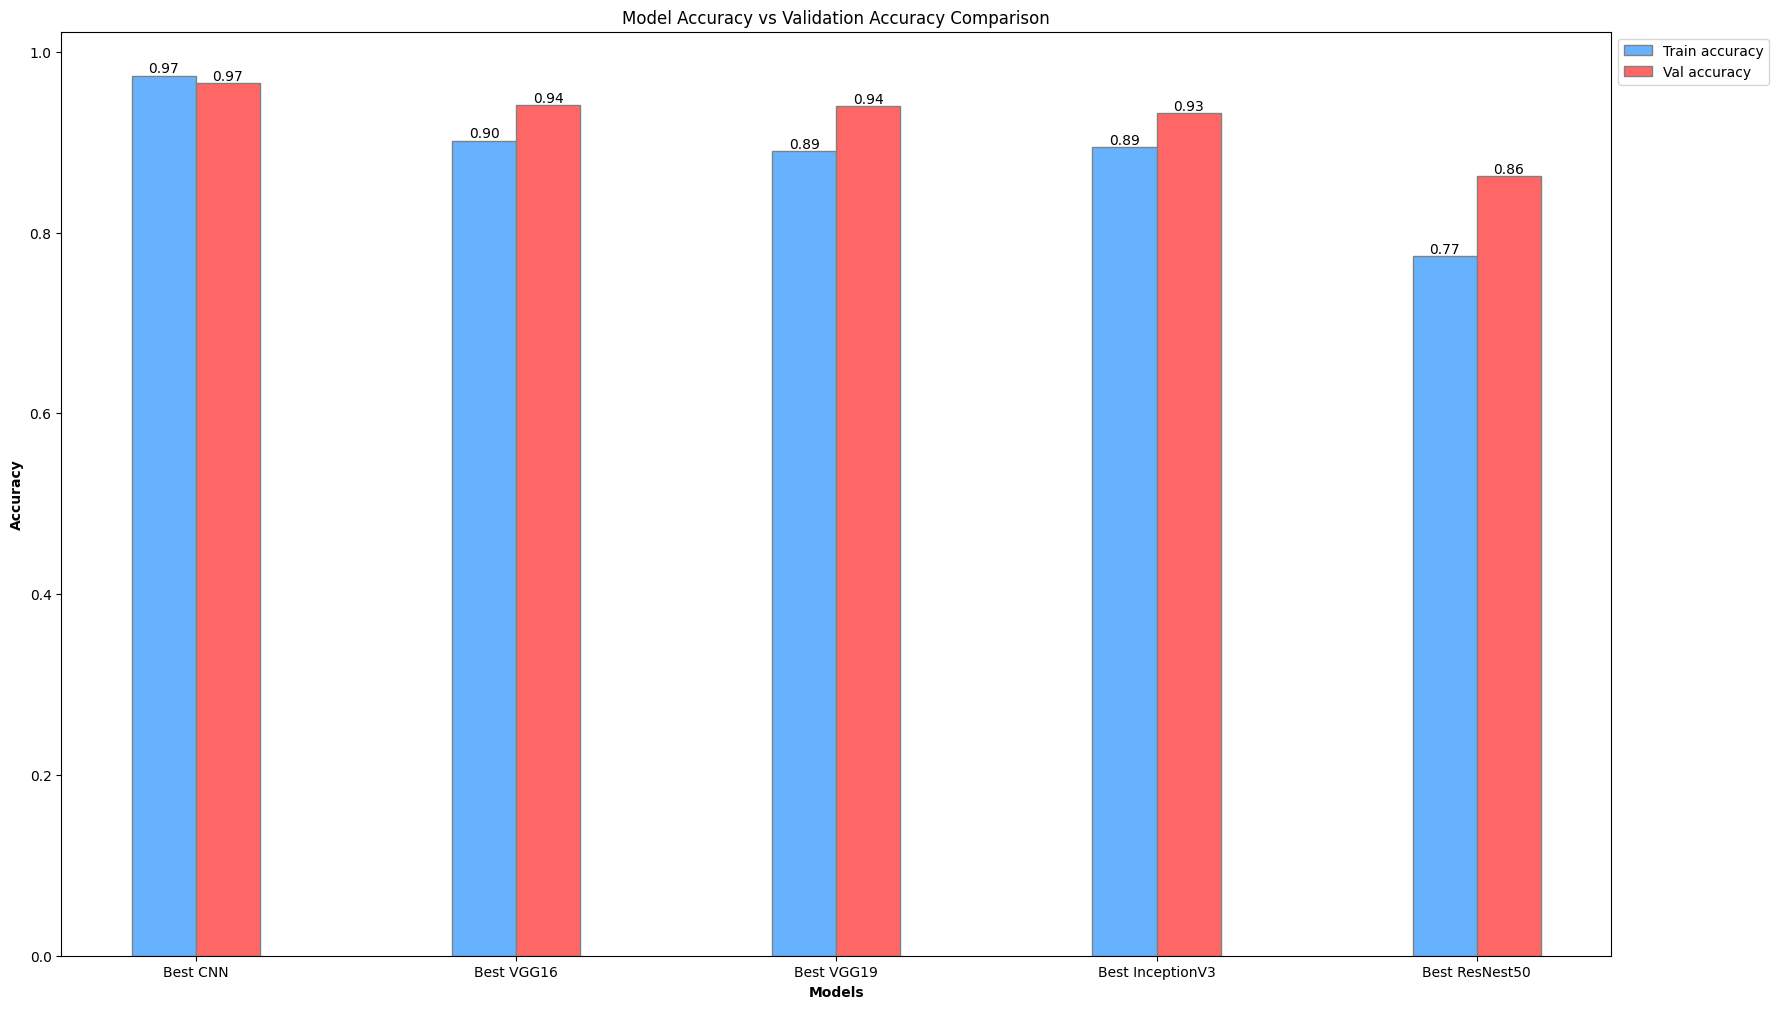

In [86]:
barWidth = 0.20

r1 = np.arange(len(best_train_accuracy))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20, 12))
bars1 = plt.bar(r1, best_train_accuracy, color='#66B2FF', width=barWidth, edgecolor='grey', label='Train accuracy')
bars2 = plt.bar(r2, best_val_accuracy, color='#FF6666', width=barWidth, edgecolor='grey', label='Val accuracy')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(best_train_accuracy))], models)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Model Accuracy vs Validation Accuracy Comparison')
plt.show()

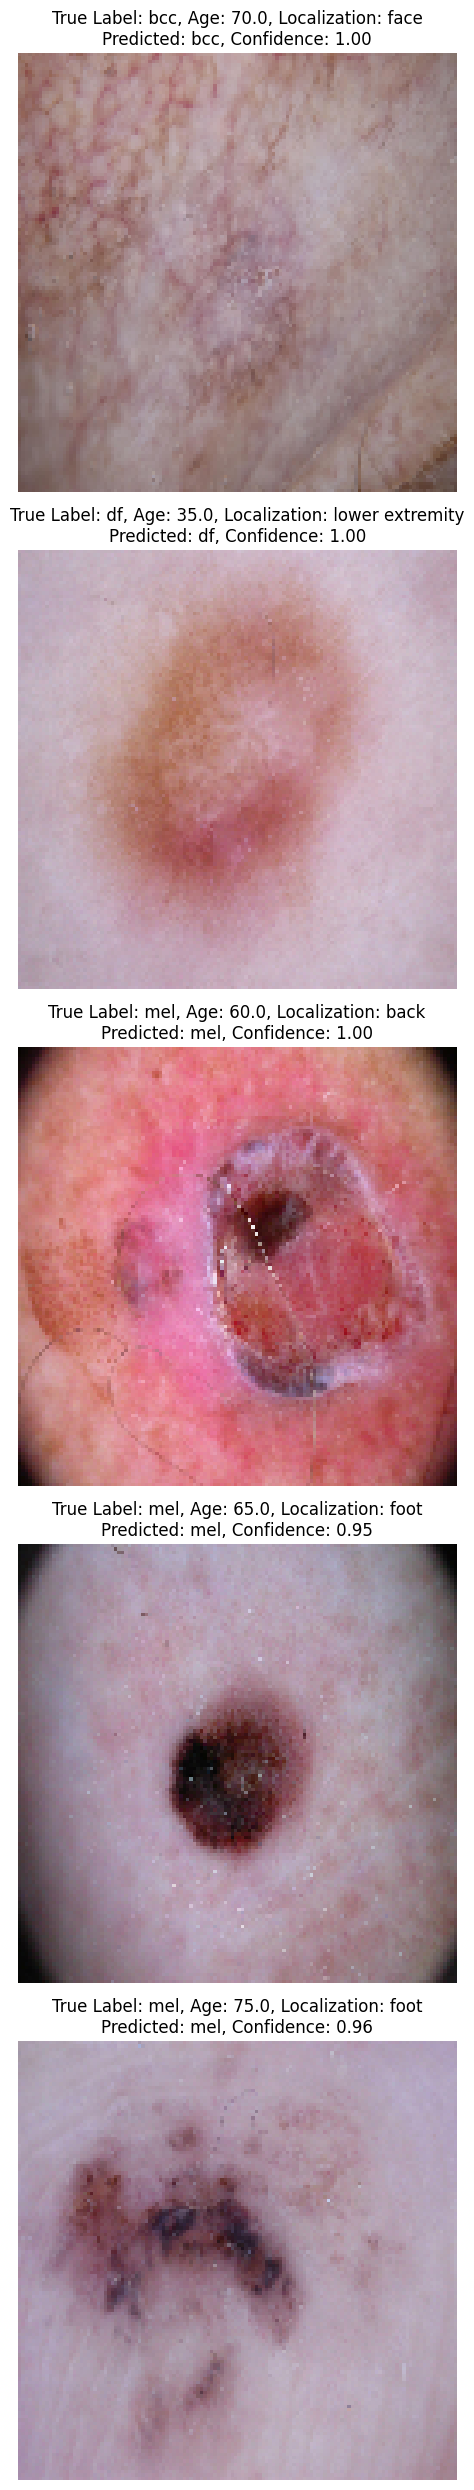

In [92]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess

# 1. Prepare Test Dataset
test_df = val_df.copy()  # Use your validation set as test set

# 2. Load Trained Models
models = {
    'CNN': load_model('best_CNN.keras'),
    'VGG16': load_model('best_VGG16.keras'),
    'VGG19': load_model('best_VGG19.keras'),
    'InceptionV3': load_model('best_InceptionV3.keras'),
    'ResNet50': load_model('best_ResNet50.keras')
}

# 3. Select 5 Random Test Images
random.seed(42)
random_indices = random.sample(range(len(test_df)), 5)
sample_images = test_df.iloc[random_indices]

# 4. Define Preprocessing Functions and Image Size
IMG_SIZE = 128
preprocess_functions = {
    'CNN': lambda x: x / 255.0,
    'VGG16': vgg16_preprocess,
    'VGG19': vgg19_preprocess,
    'InceptionV3': inceptionv3_preprocess,
    'ResNet50': resnet50_preprocess,
}

def load_and_preprocess_image(image_path, model_name):
    """Loads and preprocesses an image for a specific model."""
    try:
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preprocess = preprocess_functions.get(model_name, lambda x: x / 255.0)
    img_array = preprocess(img_array)
    return img_array

# Use @tf.function to optimize model predictions
@tf.function
def predict_with_model(model, preprocessed_image):
    return model(preprocessed_image)

# 5. Make Predictions
def get_pred_label(prediction):
    """Converts model prediction to class label and confidence score."""
    classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]  # Get the confidence of the predicted class
    return classes[predicted_class], confidence

# 6. Evaluate Accuracy for Each Model
accuracy_scores = {model_name: 0 for model_name in models.keys()}

for idx, row in sample_images.iterrows():
    image_path = row['image_id']
    true_label = row['dx']  # True label of the image
    age = row['age']
    localization = row['localization']
    
    model_predictions = {}
    
    for model_name, model in models.items():
        preprocessed_image = load_and_preprocess_image(image_path, model_name)
        if preprocessed_image is None:
            continue
        
        # Predict with the model
        prediction = predict_with_model(model, preprocessed_image)
        predicted_label, confidence = get_pred_label(prediction)
        
        # Store prediction
        model_predictions[model_name] = (predicted_label, confidence)
        
        # Compare prediction to true label for accuracy
        if predicted_label == true_label:
            accuracy_scores[model_name] += 1  # Increase accuracy count if correct

# 7. Find the Most Accurate Model
best_model_name = max(accuracy_scores, key=accuracy_scores.get)

# 8. Visualize Results
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, (idx, row) in enumerate(sample_images.iterrows()):
    image_path = row['image_id']
    true_label = row['dx']
    age = row['age']
    localization = row['localization']
    
    try:
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        continue
    
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    
    # Predict using the most accurate model
    preprocessed_image = load_and_preprocess_image(image_path, best_model_name)
    prediction = predict_with_model(models[best_model_name], preprocessed_image)
    best_label, confidence = get_pred_label(prediction)
    
    # Include true label, age, localization, predicted label, and confidence in the title
    title_text = f"True Label: {true_label}, Age: {age}, Localization: {localization}\n"
    title_text += f"Predicted: {best_label}, Confidence: {confidence:.2f}"
    
    ax.set_title(title_text, fontsize=12)
    
plt.tight_layout()
plt.show()

